In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from collections import OrderedDict
from torch.autograd import Variable
from torch.nn import init #used for initializations
import numpy as np

def conv3x3(in_channels,out_channels,stride=1,padding=1,bias=True,groups=1):
    return nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=padding,bias=bias,groups=groups)

def upconv2x2(in_channels,out_channels,mode='transpose'):
    if mode=='transpose':
        return nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2)
    else:
        return nn.Sequential(nn.Upsample(mode='Bilinear',scale_factor=2),conv1x1(in_channels,out_channels))
    
def conv1x1(in_channels,out_channels,groups=1):
    return nn.Conv2d(in_channels,out_channels,kernel_size=1,groups=groups,stride=1)

class Downconv(nn.Module):
    def __init__(self,in_channels,out_channels,pooling=True):
        
        super(Downconv,self).__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.pooling=pooling
    
        self.conv1=conv3x3(self.in_channels,self.out_channels)
        self.conv2=conv3x3(self.out_channels,self.out_channels)
    
        if self.pooling:
            self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
            
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        before_pool=x
        if self.pooling:
            x=self.pool(x)
        return x,before_pool    
        




class UpConv(nn.Module):
    
    def __init__(self,in_channels,out_channels,merge_mode='concat',up_mode='transpose'):
        super(UpConv,self).__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.merge_mode=merge_mode
        self.up_mode=up_mode
        
        self.upconv=upconv2x2(self.in_channels,self.out_channels,mode=self.up_mode)
        
        if self.merge_mode=='concat':
            self.conv1=conv3x3(2*self.out_channels,out_channels)
        else:
            self.conv1=conv3x3(self.out_channels,self.out_channels)
        self.conv2=conv3x3(self.out_channels,self.out_channels)    
        
    def forward(self,from_down,from_up):
        #from up: tensor from decoder path
        #from_down tensor to concatenate which is the before_pool tensor in encoder arch
        from_up=self.upconv(from_up)
        if self.merge_mode=='concat':
            x=torch.cat((from_up,from_down),1) #1 gives the dimension to concat along
        else:
            x=from_up+from_down
            
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        return x
    



class Unet(nn.Module):
    def __init__(self,num_classes,in_channels=3,depth=5,start_filts=64,up_mode='transpose',merge_mode='concat'):
        
        super(Unet,self).__init__()
        if up_mode in ('transpose','upsample'):
            self.up_mode=up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))
            
        
        if merge_mode in ('concat','add'):
            self.merge_mode=merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "merging. Only \"concat\" and "
                             "\"add\" are allowed.".format(merge_mode))
        
        if self.merge_mode=='add' and self.up_mode=='upsample':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")
            
        self.num_classes=num_classes
        self.in_channels=in_channels
        self.depth=depth
        self.start_filts=start_filts
        
        self.down_convs=[]
        self.up_convs=[]
        
        #create the encoder pathway and add to a list
        for i in range(depth):
            ins=self.in_channels if i==0 else outs
            outs=self.start_filts*(2**i)
            pooling=True if i<(depth-1) else False

            downconv=Downconv(ins,outs,pooling=pooling) 
            self.down_convs.append(downconv) #list of modules in the down path
            
        
        #create the decoder pathway and add to a list
        for i in range(depth-1):
            ins=outs
            outs=ins//2
            up_conv=UpConv(ins,outs,up_mode=up_mode,merge_mode=merge_mode)
            self.up_convs.append(up_conv) #list of modules in the up path 
            
        self.conv_final=conv1x1(outs,num_classes)
            
        #add the list of modules to the current module
        self.down_convs=nn.ModuleList(self.down_convs)
        self.up_convs=nn.ModuleList(self.up_convs)
            
        self.reset_params()
            
    #def weight_init(m):
        #if isinstance(m,nn.Conv2d):
            #init.xavier_normal(m.weight.double())
            #init.constant(m.bias,0)
            
    def reset_params(self):
        for i,m in enumerate(self.modules()):#self.modules returns an overall iterator over the modules of the net
            if isinstance(m,nn.Conv2d):
                init.xavier_normal(m.weight).double()
                init.constant(m.bias,0)
            
    def forward(self,x):
        encoder_outs=[]
        
        for i,module in enumerate(self.down_convs):
            x,before_pool=module(x)
            encoder_outs.append(before_pool)
            
        for i,module in enumerate(self.up_convs): 
            before_pool=encoder_outs[-(i+2)]
            x=module(before_pool,x)
        
        #no softmax but 1x1 conv is used for generating labels
        x=self.conv_final(x)
        return x



                






In [34]:
if __name__=='__main__':
    
    #testing on a random input
    model=Unet(3,depth=5,merge_mode='concat')
    x=Variable(torch.FloatTensor(np.random.random((1,3,320,320))))
    out = model(x)
    loss=torch.sum(out)
    loss.backward()

    print (loss)
    

tensor(-4966.7407, grad_fn=<SumBackward0>)


In [2]:
!pip install kaggle 


In [3]:
! mkdir ~/.kaggle


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c carvana-image-masking-challenge

 98% 791M/804M [00:04<00:00, 196MB/s]
100% 804M/804M [00:04<00:00, 195MB/s]
 99% 400M/405M [00:05<00:00, 72.0MB/s]
100% 405M/405M [00:05<00:00, 77.5MB/s]
 33% 5.00M/15.3M [00:00<00:00, 32.7MB/s]
100% 15.3M/15.3M [00:00<00:00, 74.2MB/s]
100% 7.76G/7.76G [03:15<00:00, 31.0MB/s]

100% 81.2k/81.2k [00:02<00:00, 38.6kB/s]

100% 15.4G/15.4G [06:51<00:00, 31.4MB/s]
100% 15.4G/15.4G [06:51<00:00, 40.3MB/s]
100% 107k/107k [00:02<00:00, 41.3kB/s]

  0% 0.00/202k [00:00<?, ?B/s]
100% 202k/202k [00:00<00:00, 66.7MB/s]
 58% 17.0M/29.1M [00:00<00:00, 35.1MB/s]
100% 29.1M/29.1M [00:00<00:00, 73.7MB/s]


In [7]:
 !unzip /content/train.zip

In [8]:
!pwd

/content


In [10]:
pwd

'/content'

In [11]:
!unzip /content/train.zip -d /content/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/train/0789bed99cb8_09.jpg  
  inflating: /content/train/train/0789bed99cb8_10.jpg  
  inflating: /content/train/train/0789bed99cb8_11.jpg  
  inflating: /content/train/train/0789bed99cb8_12.jpg  
  inflating: /content/train/train/0789bed99cb8_13.jpg  
  inflating: /content/train/train/0789bed99cb8_14.jpg  
  inflating: /content/train/train/0789bed99cb8_15.jpg  
  inflating: /content/train/train/0789bed99cb8_16.jpg  
  inflating: /content/train/train/0795e132d090_01.jpg  
  inflating: /content/train/train/0795e132d090_02.jpg  
  inflating: /content/train/train/0795e132d090_03.jpg  
  inflating: /content/train/train/0795e132d090_04.jpg  
  inflating: /content/train/train/0795e132d090_05.jpg  
  inflating: /content/train/train/0795e132d090_06.jpg  
  inflating: /content/train/train/0795e132d090_07.jpg  
  inflating: /content/train/train/0795e132d090_08.jpg  
  inflating: /content/train/train/0795e132d090_09.jpg

In [12]:
!unzip /content/train_masks.csv.zip -d /content/train

Archive:  /content/train_masks.csv.zip
  inflating: /content/train/train_masks.csv  


In [13]:
!unzip /content/train_masks.zip -d /content/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/train_masks/0789bed99cb8_09_mask.gif  
 extracting: /content/train/train_masks/0789bed99cb8_10_mask.gif  
 extracting: /content/train/train_masks/0789bed99cb8_11_mask.gif  
 extracting: /content/train/train_masks/0789bed99cb8_12_mask.gif  
  inflating: /content/train/train_masks/0789bed99cb8_13_mask.gif  
  inflating: /content/train/train_masks/0789bed99cb8_14_mask.gif  
  inflating: /content/train/train_masks/0789bed99cb8_15_mask.gif  
  inflating: /content/train/train_masks/0789bed99cb8_16_mask.gif  
 extracting: /content/train/train_masks/0795e132d090_01_mask.gif  
 extracting: /content/train/train_masks/0795e132d090_02_mask.gif  
 extracting: /content/train/train_masks/0795e132d090_03_mask.gif  
 extracting: /content/train/train_masks/0795e132d090_04_mask.gif  
 extracting: /content/train/train_masks/0795e132d090_05_mask.gif  
 extracting: /content/train/train_masks/0795e132d090_06_mask.gif  
 extracting

In [14]:
import os
data_dir = "train/train/"
mask_dir = "train/train_masks/"
all_images=os.listdir(data_dir) 

In [15]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.ion()
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms,utils
from sklearn.model_selection import train_test_split
import os
from skimage import io
from skimage import transform as trans

In [16]:
!unzip sample_submission.csv


Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [17]:
import pandas as pd 
ss = pd.read_csv("/content/sample_submission.csv" )

In [18]:
!unzip train_masks.csv.zip

Archive:  train_masks.csv.zip
  inflating: train_masks.csv         


In [19]:
tm = pd.read_csv("/content/train_masks.csv" )
tm

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
5083,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
5084,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
5085,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...
5086,fff9b3a5373f_15.jpg,407257 6 407393 89 409171 12 409263 179 411086...


In [20]:
ss.rle_mask

0         1 1
1         1 1
2         1 1
3         1 1
4         1 1
         ... 
100059    1 1
100060    1 1
100061    1 1
100062    1 1
100063    1 1
Name: rle_mask, Length: 100064, dtype: object

In [21]:
train_image,eval_image=train_test_split(all_images,train_size=0.8,test_size=0.2)

In [22]:

output_size=512 

In [23]:
class CarvanaDataset(Dataset):
    
    def __init__(self,data_dir,mask_dir,train_image,eval_image,Train=True,transforms=None):
        
        self.data_dir=data_dir
        self.mask_dir=mask_dir
        self.transforms=transforms
        self.train_image=train_image
        self.eval_image=eval_image
        self.Train=Train
        
    def __len__(self):
        if self.Train==True:
            return len(train_image)
        else:
            return len(eval_image)
        
    def __getitem__(self,idx):
        if self.Train==True:
            im=io.imread(os.path.join(self.data_dir,self.train_image[idx]))
            im_mask=io.imread(os.path.join(self.mask_dir,self.train_image[idx].split(".")[0]
                                         + '_mask.gif'))
            sample={'image':im,'mask':im_mask}
        else:
            im=io.imread(os.path.join(self.data_dir,eval_image[idx]))
            im_mask=io.imread(os.path.join(self.mask_dir,self.eval_image[idx].split(".")[0]+'_mask.gif'))
            sample={'image':im,'mask':im_mask}
                             
        if self.transforms:
            sample=self.transforms(sample)
                
        return sample

In [24]:

class resize(object):
    def __init__(self,output_size):
        self.output_size=output_size
        
    def __call__(self,sample):
        im,mask=sample['image'],sample['mask']
        new_h,new_w=self.output_size,self.output_size
        
        img=trans.resize(im,(new_h,new_w))
        mask_img=trans.resize(mask,(new_h,new_w))
        return {'image':img,'mask':mask_img}

class ToTensor(object):
    def __call__(self,sample):
        image,mask=sample['image'],sample['mask']
        image=image.transpose(2,0,1)
        return {'image':torch.from_numpy(image).double(),'mask':torch.from_numpy(mask).double()}


In [25]:
tsfm=transforms.Compose([resize(512),ToTensor()]) #composed transform to be applied
train_set=CarvanaDataset(data_dir,mask_dir,train_image,eval_image,Train=True,transforms=tsfm)
eval_set=CarvanaDataset(data_dir,mask_dir,train_image,eval_image,Train=False,transforms=tsfm)

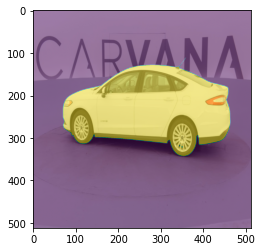

In [26]:
#displaying sample images
import cv2
sample=train_set[0]
img=sample['image'].numpy().transpose(1,2,0)
msk=sample['mask'].numpy()
#img1=sample['image']
#msk1=sample['mask']
#out = model(img1)
plt.imshow(img)
plt.imshow(msk,alpha=0.5) #image with mask
#criterion(out,msk1)

In [27]:

train_loader=DataLoader(train_set,batch_size=1,shuffle=True)
eval_loader=DataLoader(eval_set,batch_size=1,shuffle=True)

In [28]:
#!pip install UNet

In [29]:
#from UNet import Unet

In [30]:
model=Unet(3,depth=5,merge_mode='concat')
optimizer=optim.SGD(model.parameters(),momentum=0.99,lr=0.01)
criterion=nn.BCELoss()

In [ ]:
for epoch in range(1):
    running_loss=0.0
    for i,data in enumerate(train_loader):
        image=data['image'].float()
        mask=data['mask'].float()
        optimizer.zero_grad()
        output=model(image)
        
        loss=criterion(output,mask)
        loss.backward()
        optimizer.step()
        print ('image {}'.format(i))
        running_loss+=loss
        if i%100==1:
            print ("Loss={}".format(running_loss))